In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/Kvasir'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import os
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input

In [ ]:
#Defining paths
TRAIN_PATH = "/content/drive/MyDrive/Kvasir/Train"
TEST_PATH = "/content/drive/MyDrive/Kvasir/Test"

In [ ]:
BATCH_SIZE = 64

train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=40, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode="nearest", validation_split=0.1)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 6480 images belonging to 8 classes.
Found 720 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,LSTM,Dropout,TimeDistributed

In [ ]:
from keras.models import Model
from keras.layers import Input

In [ ]:
def create_model():
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.

    #target = keras.layers.Reshape(target_shape = (-1 ,224 , 224, 3), input_shape=(224,224,3)

    pre_trained_model = DenseNet201(input_shape=(224,224,3), include_top = False, weights = 'imagenet')

    for layer in pre_trained_model.layers[:-3]:
            layer.trainable = False
    for layer in pre_trained_model.layers[-3:]:
            layer.trainable = True
    
    #keras.layers.Reshape(target_shape = (-1 ,224 , 224, 3), input_shape=(224,224,3)
    x = keras.layers.Reshape(target_shape = (-1,224,224,3))(pre_trained_model.input)
    cnn_model = TimeDistributed(pre_trained_model)(x)
    cnn_model = TimeDistributed(keras.layers.Flatten())(cnn_model)
    cnn_model = TimeDistributed(Dense(1024,activation='relu'))(cnn_model)
    cnn_model = TimeDistributed(Dropout(0.5))(cnn_model)
    cnn_model = TimeDistributed(keras.layers.BatchNormalization())(cnn_model)
    #LSTM
    top_model = LSTM(200, activation='tanh', dropout=0.2, return_sequences=True)(cnn_model)
    top_model = LSTM(100, activation='tanh', dropout=0.2, return_sequences=True)(top_model)
    top_model = LSTM(50, activation='tanh', dropout=0.2, return_sequences=False)(top_model)

    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = keras.layers.BatchNormalization()(top_model)
    top_model = Dense(64,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = keras.layers.BatchNormalization()(top_model)
    top_model = Dense(32,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = keras.layers.BatchNormalization()(top_model)
    output_layer = Dense(8, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    #model = Model([target], output_layer)
    model = Model(inputs=pre_trained_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 1e-4, decay=1e-4/30), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
DenseNet_model = create_model()

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
DenseNet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 reshape (Reshape)           (None, 1, 224, 224, 3)    0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 7, 7, 1920)    18321984  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 94080)         0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 1024)          96338944  
 tributed)                                                       
                                                             

In [ ]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')
#CNN - Spatial features
#LSTM - Sequential information

In [ ]:
DenseNet_history = DenseNet_model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=30,
                            validation_data=validation_generator,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 2.4901 - accuracy: 0.1520 
Epoch 1: val_loss improved from inf to 2.13654, saving model to tl_model_v1.weights.best.hdf5
102/102 [==============================] - 1986s 19s/step - loss: 2.4901 - accuracy: 0.1520 - val_loss: 2.1365 - val_accuracy: 0.1250
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 2.3199 - accuracy: 0.1886
Epoch 2: val_loss did not improve from 2.13654
102/102 [==============================] - 186s 2s/step - loss: 2.3199 - accuracy: 0.1886 - val_loss: 2.1417 - val_accuracy: 0.1250
Epoch 3/30
102/102 [==============================] - ETA: 0s - loss: 2.1175 - accuracy: 0.2350
Epoch 3: val_loss improved from 2.13654 to 2.07331, saving model to tl_model_v1.weights.best.hdf5
102/102 [==============================] - 189s 2s/step - loss: 2.1175 - accuracy: 0.2350 - val_loss: 2.0733 - val_accuracy: 0.1250
Epoch 4/30
102/102 [==============================] - ETA: 0s - loss: 1.97

In [ ]:
# Generate predictions
DenseNet_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

In [ ]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

DenseNet_preds = DenseNet_model.predict(test_generator)
DenseNet_pred_classes = np.argmax(DenseNet_preds, axis=1)

800/800 [==============================] - 212s 257ms/step


In [ ]:
from sklearn.metrics import accuracy_score
DenseNet_acc = accuracy_score(true_classes, DenseNet_pred_classes)
print("DenseNet201 Model Accuracy: {:.2f}%".format(DenseNet_acc * 100))

DenseNet201 Model Accuracy: 88.38%


In [ ]:
labels = os.listdir(TRAIN_PATH)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_classes,DenseNet_pred_classes,target_names = labels))

                        precision    recall  f1-score   support

         normal-z-line       0.83      0.83      0.83       100
        normal-pylorus       0.86      0.83      0.84       100
dyed-resection-margins       0.82      0.76      0.79       100
          normal-cecum       0.95      0.97      0.96       100
    ulcerative-colitis       0.94      1.00      0.97       100
                polyps       0.77      0.82      0.80       100
           esophagitis       0.93      0.94      0.94       100
    dyed-lifted-polyps       0.97      0.92      0.94       100

              accuracy                           0.88       800
             macro avg       0.88      0.88      0.88       800
          weighted avg       0.88      0.88      0.88       800



In [ ]:
from sklearn.metrics import precision_score
precision_score(true_classes, DenseNet_pred_classes, average='micro')

0.88375

In [ ]:
from sklearn.metrics import recall_score
recall_score(true_classes, DenseNet_pred_classes, average='micro')

0.88375

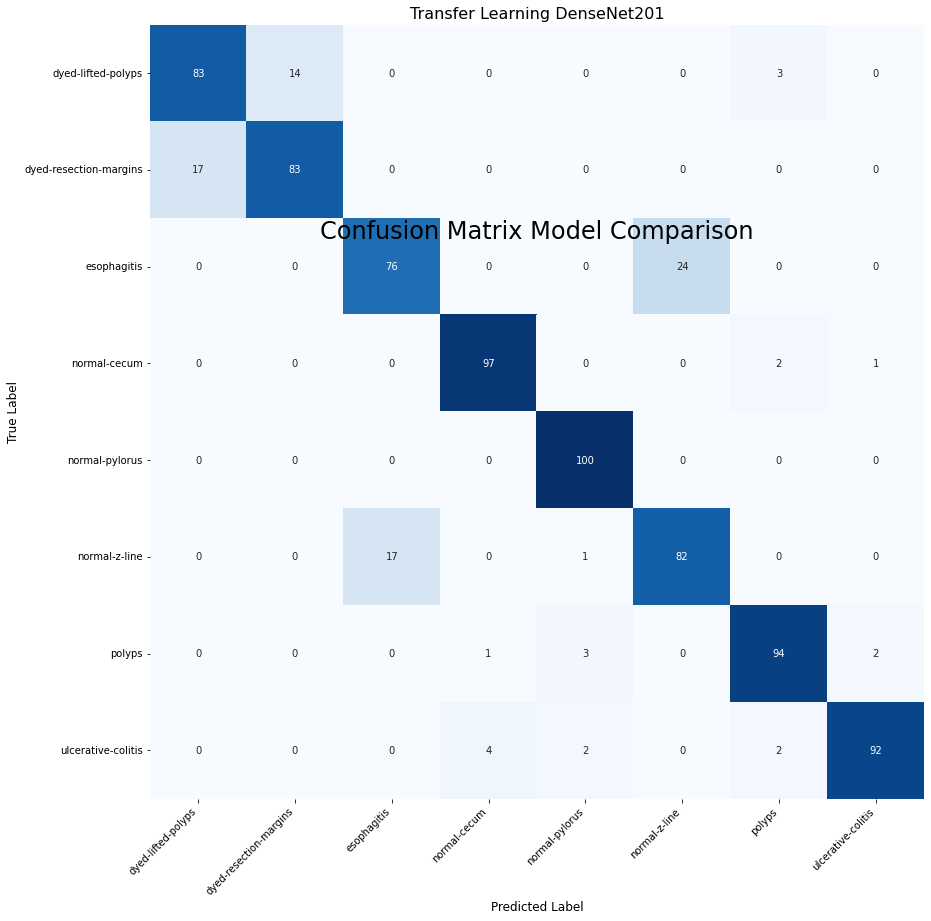

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1,figsize=(20, 10))
    
plot_heatmap(true_classes, DenseNet_pred_classes, class_names, ax1, title="Transfer Learning DenseNet201")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=11956924a330e1b6b304db71435ed91d416e283a4e63e70e5ffb97d96976c80d
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_image

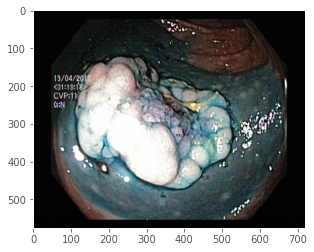

Predicted Class: dyed-lifted-polyps
Prediction Score:  0.9986766
Expected Class: dyed-lifted-polyps


In [ ]:
import skimage
import skimage.transform
from skimage import io
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams["axes.grid"] = False
img_path = '/content/drive/MyDrive/Kvasir/Test/dyed-lifted-polyps/e4d0114e-09a3-468a-8f2c-92702d03584c.jpg'
plt_img=mpimg.imread(img_path)


def transform_image(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (224,224,3))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = transform_image(img_path)

preds = DenseNet_model.predict(images)
prediction_class = np.argmax(preds, axis=1)
#prediction_class = DenseNet_model.predict_classes(images)
prediction = np.argmax(preds)
prediction_score = np.max(preds)
if prediction_class == 0:
    txt = "dyed-lifted-polyps"
elif prediction_class == 1:
    txt = "dyed-resection-margins"
elif prediction_class == 2:
    txt = "esophagitis"
elif prediction_class == 3:
    txt = "normal-cecum"
elif prediction_class == 4:
    txt = "normal-pylorus"
elif prediction_class == 5:
    txt = "normal-z-line"
elif prediction_class == 6:
    txt = "polyps"
elif prediction_class == 7:
    txt = "ulcerative-colitis"
plt.imshow(plt_img)
plt.show()
print("Predicted Class: "+txt)
print("Prediction Score: ",prediction_score)
print("Expected Class: "+"dyed-lifted-polyps")

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(images[0].astype('double'), DenseNet_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

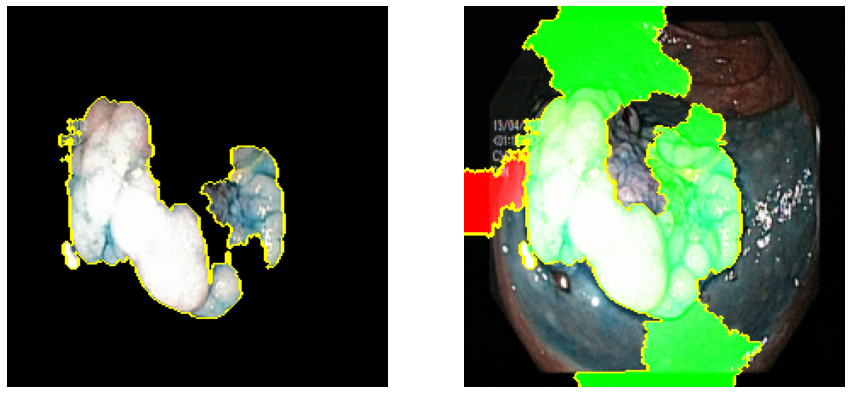

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')

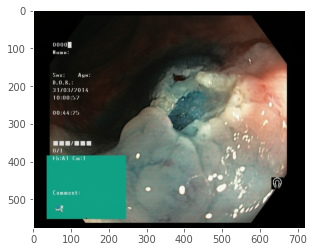

Predicted Class: dyed-resection-margins
Prediction Score:  0.90832645
Expected Class: dyed-resection-margins


In [ ]:
img_path = '/content/drive/MyDrive/Kvasir/Test/dyed-resection-margins/de582410-cd28-4236-9b46-37a10aa6064b.jpg'
plt_img=mpimg.imread(img_path)


def transform_image(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (224,224,3))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = transform_image(img_path)

preds = DenseNet_model.predict(images)
prediction_class = np.argmax(preds, axis=1)
#prediction_class = DenseNet_model.predict_classes(images)
prediction = np.argmax(preds)
prediction_score = np.max(preds)
if prediction_class == 0:
    txt = "dyed-lifted-polyps"
elif prediction_class == 1:
    txt = "dyed-resection-margins"
elif prediction_class == 2:
    txt = "esophagitis"
elif prediction_class == 3:
    txt = "normal-cecum"
elif prediction_class == 4:
    txt = "normal-pylorus"
elif prediction_class == 5:
    txt = "normal-z-line"
elif prediction_class == 6:
    txt = "polyps"
elif prediction_class == 7:
    txt = "ulcerative-colitis"
plt.imshow(plt_img)
plt.show()
print("Predicted Class: "+txt)
print("Prediction Score: ",prediction_score)
print("Expected Class: "+"dyed-resection-margins")

In [ ]:
images = transform_image(img_path)
explanation = explainer.explain_instance(images[0].astype('double'), DenseNet_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

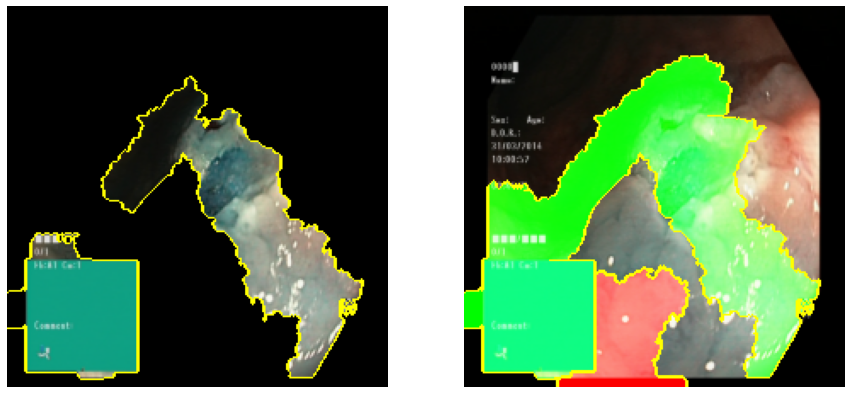

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')

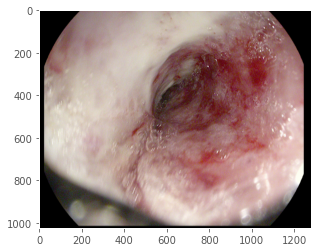

Predicted Class: esophagitis
Prediction Score:  0.97391033
Expected Class: esophagitis


In [ ]:
img_path = '/content/drive/MyDrive/Kvasir/Test/esophagitis/d4064274-fd37-4043-a0ac-7dc329fb85f7.jpg'
plt_img=mpimg.imread(img_path)


def transform_image(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (224,224,3))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = transform_image(img_path)

preds = DenseNet_model.predict(images)
prediction_class = np.argmax(preds, axis=1)
#prediction_class = DenseNet_model.predict_classes(images)
prediction = np.argmax(preds)
prediction_score = np.max(preds)
if prediction_class == 0:
    txt = "dyed-lifted-polyps"
elif prediction_class == 1:
    txt = "dyed-resection-margins"
elif prediction_class == 2:
    txt = "esophagitis"
elif prediction_class == 3:
    txt = "normal-cecum"
elif prediction_class == 4:
    txt = "normal-pylorus"
elif prediction_class == 5:
    txt = "normal-z-line"
elif prediction_class == 6:
    txt = "polyps"
elif prediction_class == 7:
    txt = "ulcerative-colitis"
plt.imshow(plt_img)
plt.show()
print("Predicted Class: "+txt)
print("Prediction Score: ",prediction_score)
print("Expected Class: "+"esophagitis")

In [ ]:
images = transform_image(img_path)
explanation = explainer.explain_instance(images[0].astype('double'), DenseNet_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

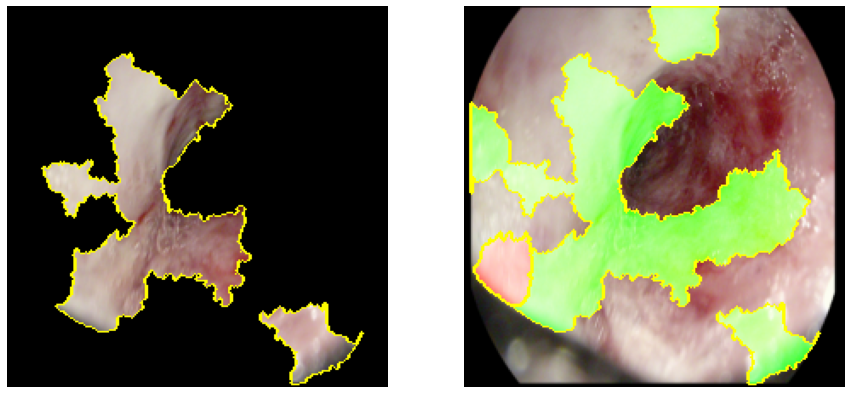

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')

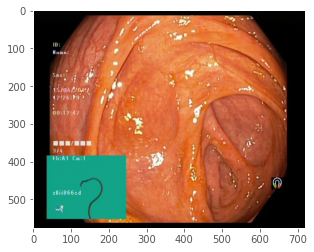

Predicted Class: normal-cecum
Prediction Score:  0.9999379
Expected Class: normal-cecum


In [ ]:
img_path = '/content/drive/MyDrive/Kvasir/Test/normal-cecum/e0fe569d-cc8d-4871-88d0-5477f4aa6e66.jpg'
plt_img=mpimg.imread(img_path)


def transform_image(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (224,224,3))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = transform_image(img_path)

preds = DenseNet_model.predict(images)
prediction_class = np.argmax(preds, axis=1)
#prediction_class = DenseNet_model.predict_classes(images)
prediction = np.argmax(preds)
prediction_score = np.max(preds)
if prediction_class == 0:
    txt = "dyed-lifted-polyps"
elif prediction_class == 1:
    txt = "dyed-resection-margins"
elif prediction_class == 2:
    txt = "esophagitis"
elif prediction_class == 3:
    txt = "normal-cecum"
elif prediction_class == 4:
    txt = "normal-pylorus"
elif prediction_class == 5:
    txt = "normal-z-line"
elif prediction_class == 6:
    txt = "polyps"
elif prediction_class == 7:
    txt = "ulcerative-colitis"
plt.imshow(plt_img)
plt.show()
print("Predicted Class: "+txt)
print("Prediction Score: ",prediction_score)
print("Expected Class: "+"normal-cecum")

In [ ]:
images = transform_image(img_path)
explanation = explainer.explain_instance(images[0].astype('double'), DenseNet_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

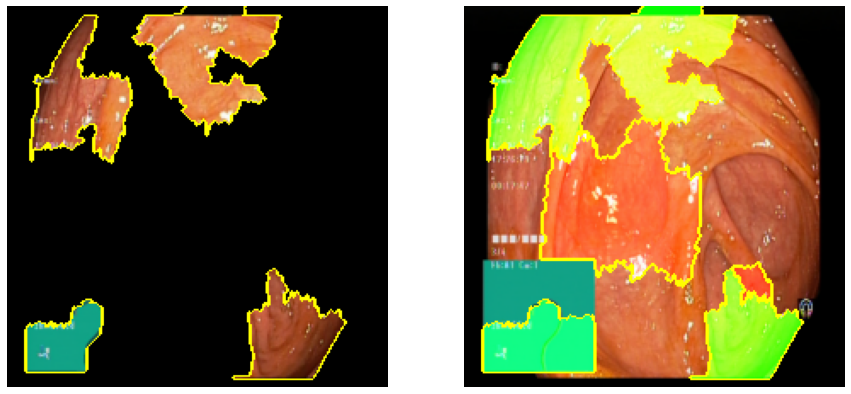

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')

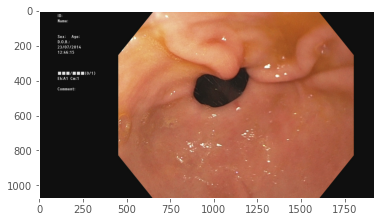

Predicted Class: normal-pylorus
Prediction Score:  0.99999964
Expected Class: normal-pylorus


In [ ]:
img_path = '/content/drive/MyDrive/Kvasir/Test/normal-pylorus/e7863b31-857d-4717-9685-e863a0987289.jpg'
plt_img=mpimg.imread(img_path)


def transform_image(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (224,224,3))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = transform_image(img_path)

preds = DenseNet_model.predict(images)
prediction_class = np.argmax(preds, axis=1)
#prediction_class = DenseNet_model.predict_classes(images)
prediction = np.argmax(preds)
prediction_score = np.max(preds)
if prediction_class == 0:
    txt = "dyed-lifted-polyps"
elif prediction_class == 1:
    txt = "dyed-resection-margins"
elif prediction_class == 2:
    txt = "esophagitis"
elif prediction_class == 3:
    txt = "normal-cecum"
elif prediction_class == 4:
    txt = "normal-pylorus"
elif prediction_class == 5:
    txt = "normal-z-line"
elif prediction_class == 6:
    txt = "polyps"
elif prediction_class == 7:
    txt = "ulcerative-colitis"
plt.imshow(plt_img)
plt.show()
print("Predicted Class: "+txt)
print("Prediction Score: ",prediction_score)
print("Expected Class: "+"normal-pylorus")

In [ ]:
images = transform_image(img_path)
explanation = explainer.explain_instance(images[0].astype('double'), DenseNet_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

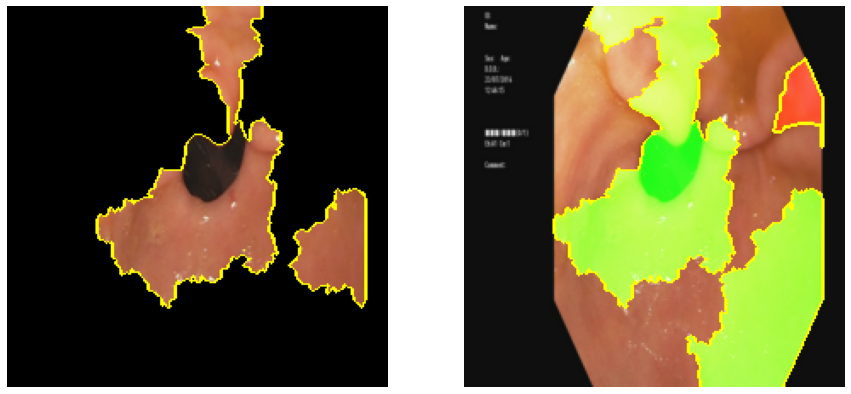

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')

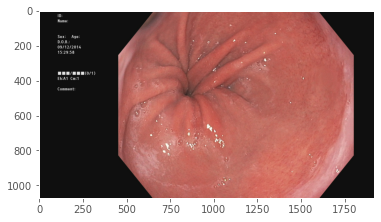

Predicted Class: normal-pylorus
Prediction Score:  0.99719703
Expected Class: normal-z-line


In [ ]:
img_path = '/content/drive/MyDrive/Kvasir/Test/normal-z-line/e12231c4-5e1f-4375-96db-950e87f3e107.jpg'
plt_img=mpimg.imread(img_path)


def transform_image(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (224,224,3))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = transform_image(img_path)

preds = DenseNet_model.predict(images)
prediction_class = np.argmax(preds, axis=1)
#prediction_class = DenseNet_model.predict_classes(images)
prediction = np.argmax(preds)
prediction_score = np.max(preds)
if prediction_class == 0:
    txt = "dyed-lifted-polyps"
elif prediction_class == 1:
    txt = "dyed-resection-margins"
elif prediction_class == 2:
    txt = "esophagitis"
elif prediction_class == 3:
    txt = "normal-cecum"
elif prediction_class == 4:
    txt = "normal-pylorus"
elif prediction_class == 5:
    txt = "normal-z-line"
elif prediction_class == 6:
    txt = "polyps"
elif prediction_class == 7:
    txt = "ulcerative-colitis"
plt.imshow(plt_img)
plt.show()
print("Predicted Class: "+txt)
print("Prediction Score: ",prediction_score)
print("Expected Class: "+"normal-z-line")

In [ ]:
images = transform_image(img_path)
explanation = explainer.explain_instance(images[0].astype('double'), DenseNet_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

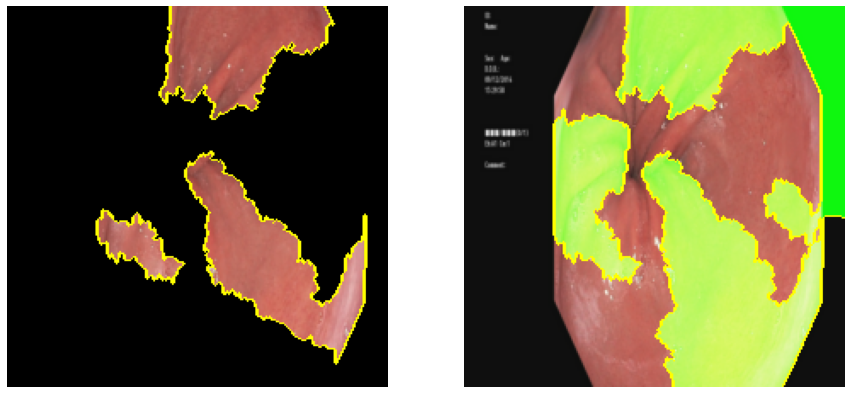

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')

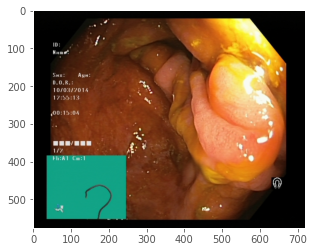

Predicted Class: polyps
Prediction Score:  0.9402415
Expected Class: polyps


In [ ]:
img_path = '/content/drive/MyDrive/Kvasir/Test/polyps/daf17a17-8a46-4e05-9ac1-6b8b99a97919.jpg'
plt_img=mpimg.imread(img_path)


def transform_image(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (224,224,3))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = transform_image(img_path)

preds = DenseNet_model.predict(images)
prediction_class = np.argmax(preds, axis=1)
#prediction_class = DenseNet_model.predict_classes(images)
prediction = np.argmax(preds)
prediction_score = np.max(preds)
if prediction_class == 0:
    txt = "dyed-lifted-polyps"
elif prediction_class == 1:
    txt = "dyed-resection-margins"
elif prediction_class == 2:
    txt = "esophagitis"
elif prediction_class == 3:
    txt = "normal-cecum"
elif prediction_class == 4:
    txt = "normal-pylorus"
elif prediction_class == 5:
    txt = "normal-z-line"
elif prediction_class == 6:
    txt = "polyps"
elif prediction_class == 7:
    txt = "ulcerative-colitis"
plt.imshow(plt_img)
plt.show()
print("Predicted Class: "+txt)
print("Prediction Score: ",prediction_score)
print("Expected Class: "+"polyps")

In [ ]:
images = transform_image(img_path)
explanation = explainer.explain_instance(images[0].astype('double'), DenseNet_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

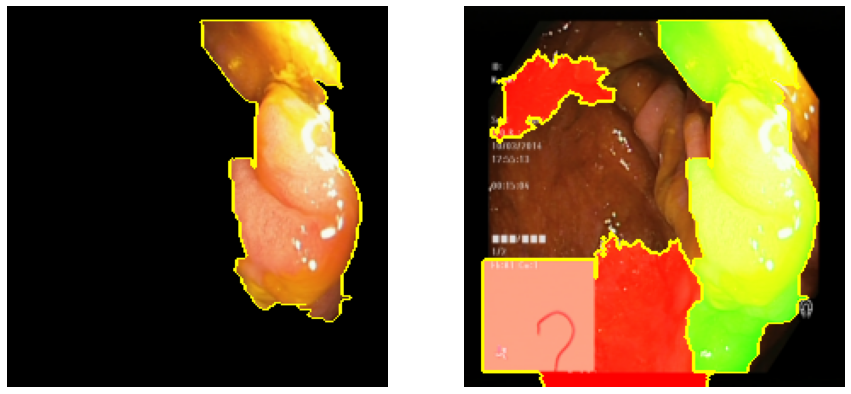

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')

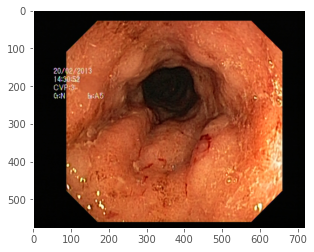

Predicted Class: ulcerative-colitis
Prediction Score:  0.9221497
Expected Class: ulcerative-colitis


In [ ]:
img_path = '/content/drive/MyDrive/Kvasir/Test/ulcerative-colitis/e0095761-ad92-4e86-8227-42bbe9cac257.jpg'
plt_img=mpimg.imread(img_path)


def transform_image(img_path):

    img = skimage.io.imread(img_path)
    img = skimage.transform.resize(img, (224,224,3))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = transform_image(img_path)

preds = DenseNet_model.predict(images)
prediction_class = np.argmax(preds, axis=1)
#prediction_class = DenseNet_model.predict_classes(images)
prediction = np.argmax(preds)
prediction_score = np.max(preds)
if prediction_class == 0:
    txt = "dyed-lifted-polyps"
elif prediction_class == 1:
    txt = "dyed-resection-margins"
elif prediction_class == 2:
    txt = "esophagitis"
elif prediction_class == 3:
    txt = "normal-cecum"
elif prediction_class == 4:
    txt = "normal-pylorus"
elif prediction_class == 5:
    txt = "normal-z-line"
elif prediction_class == 6:
    txt = "polyps"
elif prediction_class == 7:
    txt = "ulcerative-colitis"
plt.imshow(plt_img)
plt.show()
print("Predicted Class: "+txt)
print("Prediction Score: ",prediction_score)
print("Expected Class: "+"ulcerative-colitis")

In [ ]:
images = transform_image(img_path)
explanation = explainer.explain_instance(images[0].astype('double'), DenseNet_model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

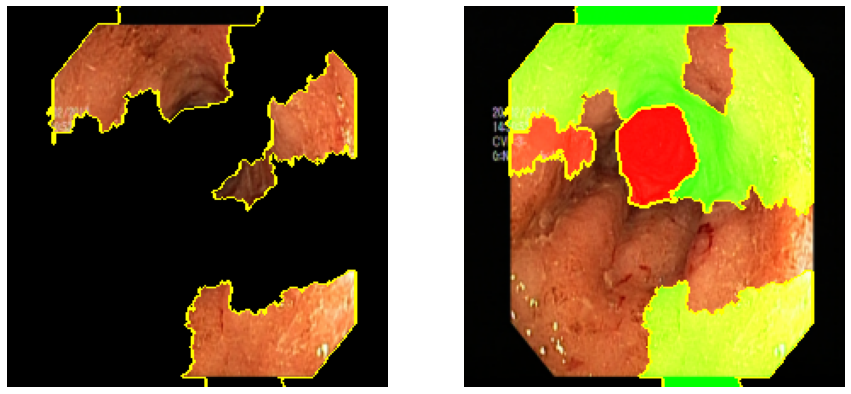

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')

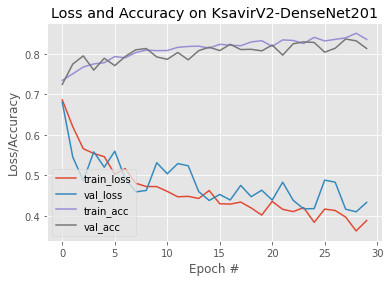

In [ ]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), DenseNet_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), DenseNet_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), DenseNet_history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), DenseNet_history.history["val_accuracy"], label="val_acc")
plt.title("Loss and Accuracy on KsavirV2-DenseNet201")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")